In [64]:
import sys
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point  # 공간 정보 처리

In [4]:
print("Python version :", sys.version)
print("Numpy version :", np.__version__)
print("Pandas version :", pd.__version__)
print("Geopandas version :", gpd.__version__)

Python version : 3.11.3 | packaged by Anaconda, Inc. | (main, May 15 2023, 15:41:31) [MSC v.1916 64 bit (AMD64)]
Numpy version : 1.26.2
Pandas version : 2.1.3
Geopandas version : 0.14.1


## 데이터 확인 및 전처리

In [20]:
df_train = pd.read_csv("./data/train.csv")

df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


In [21]:
# 컬럼별 데이터 라벨 확인

df_train.nunique()

ID             39609
사고일시           18057
요일                 7
기상상태               6
시군구              199
도로형태              11
노면상태               6
사고유형               3
사고유형 - 세부분류       14
법규위반              11
가해운전자 차종          12
가해운전자 성별           3
가해운전자 연령          89
가해운전자 상해정도         6
피해운전자 차종          13
피해운전자 성별           3
피해운전자 연령          97
피해운전자 상해정도         6
사망자수               3
중상자수               7
경상자수              18
부상자수               9
ECLO              46
dtype: int64

In [23]:
# 테스트 데이터 데이터 확인

df_test = pd.read_csv("./data/test.csv")

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    10963 non-null  object
dtypes: object(8)
memory usage: 685.3+ KB


In [24]:
# 테스트 데이터 라벨 확인

df_test.nunique()

ID      10963
사고일시     5548
요일          7
기상상태        5
시군구       192
도로형태       11
노면상태        6
사고유형        3
dtype: int64

In [29]:
# train-test 중 겹치는 컬럼의 데이터 라벨 확인

col_test = df_test.columns[1:]

for c in col_test : 
    print(c+"의 train unique")
    print(sorted(df_train[c].unique().tolist()))
    print("-----------------------")
    print(c+"의 test unique")
    print(sorted(df_test[c].unique().tolist()))
    print("********************")


# 시군구의 경우 test에 존재하는 값이 train에 전부 존재하는지 확인

사고일시의 train unique
['2019-01-01 00', '2019-01-01 01', '2019-01-01 02', '2019-01-01 04', '2019-01-01 05', '2019-01-01 06', '2019-01-01 10', '2019-01-01 11', '2019-01-01 14', '2019-01-01 18', '2019-01-01 19', '2019-01-01 20', '2019-01-01 22', '2019-01-02 01', '2019-01-02 02', '2019-01-02 07', '2019-01-02 08', '2019-01-02 10', '2019-01-02 11', '2019-01-02 13', '2019-01-02 14', '2019-01-02 15', '2019-01-02 16', '2019-01-02 17', '2019-01-02 18', '2019-01-02 19', '2019-01-02 20', '2019-01-02 22', '2019-01-02 23', '2019-01-03 00', '2019-01-03 02', '2019-01-03 03', '2019-01-03 05', '2019-01-03 07', '2019-01-03 08', '2019-01-03 10', '2019-01-03 11', '2019-01-03 12', '2019-01-03 13', '2019-01-03 14', '2019-01-03 15', '2019-01-03 17', '2019-01-03 18', '2019-01-03 19', '2019-01-03 20', '2019-01-03 21', '2019-01-03 22', '2019-01-03 23', '2019-01-04 00', '2019-01-04 01', '2019-01-04 04', '2019-01-04 05', '2019-01-04 06', '2019-01-04 07', '2019-01-04 08', '2019-01-04 10', '2019-01-04 11', '2019-01-04

In [36]:
uni_city = df_test["시군구"].unique().tolist()

len_city_test = len(uni_city)

len_city_train = len(df_train[df_train["시군구"].isin(uni_city)]["시군구"].unique())

if len_city_test == len_city_train : 
    print("test data의 시군구 값은 train data에 전부 속합니다.")

test data의 시군구 값은 train data에 전부 속합니다.


In [40]:
# 사고 일시 object -> datetime

df_train["사고일시"] = pd.to_datetime(df_train["사고일시"], format="%Y-%m-%d %H")
df_test["사고일시"] = pd.to_datetime(df_test["사고일시"], format="%Y-%m-%d %H")

print(df_train["사고일시"].dtypes)
print(df_test["사고일시"].dtypes)

datetime64[ns]
datetime64[ns]


In [45]:
# 숫자 데이터이지만 object인 변수의 타입을 변경

df_train[["사망자수",'중상자수','경상자수','부상자수',"ECLO"]] = df_train[["사망자수",'중상자수','경상자수','부상자수',"ECLO"]].astype(int)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           39609 non-null  object        
 1   사고일시         39609 non-null  datetime64[ns]
 2   요일           39609 non-null  object        
 3   기상상태         39609 non-null  object        
 4   시군구          39609 non-null  object        
 5   도로형태         39609 non-null  object        
 6   노면상태         39609 non-null  object        
 7   사고유형         39609 non-null  object        
 8   사고유형 - 세부분류  39609 non-null  object        
 9   법규위반         39609 non-null  object        
 10  가해운전자 차종     39609 non-null  object        
 11  가해운전자 성별     39609 non-null  object        
 12  가해운전자 연령     39609 non-null  object        
 13  가해운전자 상해정도   39609 non-null  object        
 14  피해운전자 차종     38618 non-null  object        
 15  피해운전자 성별     38618 non-null  object        
 16  피해운전

In [46]:
# 컬럼별 결측치 갯수 확인

df_train.isnull().sum()

ID               0
사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해운전자 연령       991
피해운전자 상해정도     991
사망자수             0
중상자수             0
경상자수             0
부상자수             0
ECLO             0
dtype: int64

결측치의 대부분이 피해 운전자이므로, 결측치가 존재하는 데이터의 사고 유형 등을 확인

In [52]:
df_train_null = df_train[df_train["피해운전자 차종"].isnull()]

print("null인 데이터의 사고 종류 :",df_train_null["사고유형"].unique())
print("null인 데이터의 상해 정도 종류 :",df_train_null["가해운전자 상해정도"].unique())

# 차량 단독으로 일어난 사고이므로 피해자가 없음, 차량 단독이지만 상해 종류는 다양

null인 데이터의 사고 종류 : ['차량단독']
null인 데이터의 상해 정도 종류 : ['중상' '경상' '상해없음' '부상신고' '사망' '기타불명']


In [53]:
# '차량 단독'이 전체 데이터 중 어느 정도 비율을 차지하는지 확인

df_train["사고유형"].value_counts()

사고유형
차대차     31785
차대사람     6833
차량단독      991
Name: count, dtype: int64

차량 단독의 전체 개수가 null 값인 사고 유형의 갯수와 일치하므로, 차량 단독 데이터를 제거할 수 없고 결측치 처리 필요

In [55]:
# 피해 운전자 관련 데이터의 label 확인

pihae = ['피해운전자 차종','피해운전자 성별','피해운전자 연령','피해운전자 상해정도']

for i in range(4) : 
    print(df_train[pihae[i]].unique())
    print("--------------------------")


# null 값을 '기타불명', '미분류' 등으로 대체

['보행자' '승용' '자전거' '승합' nan '이륜' '화물' '개인형이동수단(PM)' '사륜오토바이(ATV)' '특수'
 '원동기' '기타불명' '건설기계' '농기계']
--------------------------
['여' '남' nan '기타불명']
--------------------------
['70세' '61세' '38세' '36세' '52세' '35세' '76세' '53세' '62세' '42세' '60세' '69세'
 '31세' '23세' nan '57세' '17세' '54세' '55세' '64세' '41세' '44세' '58세' '45세'
 '30세' '59세' '34세' '68세' '32세' '21세' '56세' '18세' '37세' '39세' '27세' '65세'
 '43세' '12세' '75세' '4세' '71세' '40세' '48세' '14세' '19세' '66세' '63세' '50세'
 '20세' '67세' '26세' '22세' '47세' '16세' '28세' '46세' '51세' '29세' '33세' '24세'
 '79세' '80세' '74세' '78세' '72세' '49세' '73세' '5세' '13세' '77세' '9세' '86세'
 '15세' '84세' '25세' '82세' '10세' '8세' '85세' '7세' '11세' '88세' '미분류' '87세'
 '83세' '90세 이상' '3세' '81세' '6세' '89세' '2세' '1세' '91세' '90세' '93세' '94세'
 '92세' '98세 이상']
--------------------------
['중상' '경상' '상해없음' nan '부상신고' '사망' '기타불명']
--------------------------


In [56]:
# 결측치 채움

fill = ["기타불명", "기타불명", "미분류", "기타불명"]

for i in range(4) : 
    df_train[pihae[i]].fillna(fill[i], inplace=True)

df_train.isnull().sum()

ID             0
사고일시           0
요일             0
기상상태           0
시군구            0
도로형태           0
노면상태           0
사고유형           0
사고유형 - 세부분류    0
법규위반           0
가해운전자 차종       0
가해운전자 성별       0
가해운전자 연령       0
가해운전자 상해정도     0
피해운전자 차종       0
피해운전자 성별       0
피해운전자 연령       0
피해운전자 상해정도     0
사망자수           0
중상자수           0
경상자수           0
부상자수           0
ECLO           0
dtype: int64

### 외부 데이터 불러오기

In [59]:
# cctv 데이터

cctv = pd.read_csv("./data/external_open/대구 CCTV 정보.csv", encoding='cp949')

cctv.info()
cctv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   무인교통단속카메라관리번호  1065 non-null   object 
 1   시도명            1065 non-null   object 
 2   시군구명           1065 non-null   object 
 3   도로종류           1065 non-null   object 
 4   도로노선번호         288 non-null    object 
 5   도로노선명          1065 non-null   object 
 6   도로노선방향         1065 non-null   int64  
 7   소재지도로명주소       905 non-null    object 
 8   소재지지번주소        1063 non-null   object 
 9   위도             1065 non-null   float64
 10  경도             1065 non-null   float64
 11  설치장소           1065 non-null   object 
 12  단속구분           1065 non-null   int64  
 13  제한속도           1065 non-null   int64  
 14  단속구간위치구분       53 non-null     float64
 15  과속단속구간길이       26 non-null     float64
 16  보호구역구분         893 non-null    float64
 17  설치연도           1065 non-null   float64
dtypes: float

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.838857,128.575418,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.0,2010.0
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.844653,128.604619,효성백년가약,4,0,NaN,NaN,99.0,2013.0
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,대구광역시 남구 봉덕동 866-46,35.844183,128.604815,강변코오롱하늘채,4,0,NaN,NaN,99.0,2013.0
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,대구광역시 남구 대명동 2680-17,35.834798,128.585284,보성청록타운,4,0,NaN,NaN,99.0,2014.0
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,대구광역시 남구 봉덕동 1616,35.832728,128.588324,환경차고지,4,0,NaN,NaN,99.0,2014.0


In [99]:
cctv[["단속구분", "제한속도"]].value_counts().sort_index(ascending=False).to_frame()

count
단속구분 제한속도       
99   100      16
     80       25
     60        2
     50        4
     40        2
     30        2
4    0       232
2    80        3
     70       13
     60      126
     50      218
     40       67
     30      148
1    110       1
     100       3
     80        4
     70        9
     60       59
     50       52
     40       11
     30       68

보통 제한 속도를 보면서 운전을 하는 것이 아니라 cctv가 있을 때 속도를 줄이므로,  
단속 구분과 제한 속도는 의미가 없고 행정 구역별 갯수가 유의미할 것으로 판단

In [60]:
# 보안등 데이터

light = pd.read_csv("./data/external_open/대구 보안등 정보.csv", encoding='cp949')

light.info()
light.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71913 entries, 0 to 71912
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   보안등위치명    71913 non-null  object 
 1   설치개수      71913 non-null  int64  
 2   소재지도로명주소  34646 non-null  object 
 3   소재지지번주소   71913 non-null  object 
 4   위도        43602 non-null  float64
 5   경도        43602 non-null  float64
 6   설치연도      29397 non-null  float64
 7   설치형태      35373 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 4.4+ MB


C:\Users\jhahn\AppData\Local\Temp\ipykernel_18072\2683355564.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  light = pd.read_csv("./data/external_open/대구 보안등 정보.csv", encoding='cp949')


,보안등위치명,설치개수,소재지도로명주소,소재지지번주소,위도,경도,설치연도,설치형태
0,대명1동1,1,대구광역시 남구 현충로 155,대구광역시 남구 대명동 1722-4,35.846703,128.579803,2016.0,한전주
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,대구광역시 남구 대명동 1723-11,35.846863,128.579406,2016.0,한전주
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,대구광역시 남구 대명동 1722-56,35.846341,128.579342,2017.0,건축물
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,대구광역시 남구 대명동 1722-41,35.846368,128.578922,2016.0,한전주
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,대구광역시 남구 대명동 1721-22,35.845995,128.578858,2016.0,한전주


In [61]:
# 어린이 보호 구역 데이터

child = pd.read_csv("./data/external_open/대구 어린이 보호 구역 정보.csv", encoding='cp949')

child.info()
child.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시설종류      640 non-null    object 
 1   대상시설명     640 non-null    object 
 2   소재지도로명주소  640 non-null    object 
 3   소재지지번주소   555 non-null    object 
 4   위도        640 non-null    float64
 5   경도        640 non-null    float64
 6   관리기관명     640 non-null    object 
 7   관할경찰서명    640 non-null    object 
 8   CCTV설치여부  640 non-null    object 
 9   CCTV설치대수  465 non-null    float64
 10  보호구역도로폭   320 non-null    object 
 11  데이터기준일자   640 non-null    object 
dtypes: float64(3), object(9)
memory usage: 60.1+ KB


,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),대구광역시 남구 대명동 1709,35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),대구광역시 남구 이천동 477,35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),대구광역시 남구 대명동 3050,35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,대구광역시 남구 대명동 531-1,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,대구광역시 남구 대명동 960,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23


In [106]:
# cctv 설치여부 Y -> 1, N -> 0으로 변경

child["CCTV설치여부"].replace({"Y":1, "N":0}, inplace=True)

child["CCTV설치여부"].unique()

array([1, 0], dtype=int64)

In [130]:
data_sch = child["대상시설명"].value_counts()

data_sch[data_sch > 1]

대상시설명
죽곡어린이집       2
화원초등         2
죽곡초등         2
천내초등         2
하빈면초등        2
            ..
세종유치원(성림)    2
숲속예은유치원      2
신영유치원        2
신솔정유치원       2
이튼어린이집       2
Name: count, Length: 102, dtype: int64

In [127]:
child[child["대상시설명"]=="죽곡어린이집"]

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,주소_수정
104,어린이집,죽곡어린이집,대구광역시 달성군 달구벌대로174길17-5,대구광역시 달성군 다사읍 죽곡리 197,35.857921,128.462075,대구광역시 달성군청,달성경찰서,0,0.0,NaN,2019-09-10,NaN
203,어린이집,죽곡어린이집,대구광역시 달성군 달구벌대로174길17-5,대구광역시 달성군 다사읍 죽곡리 197,35.857921,128.462075,대구광역시 달성군청,달성경찰서,0,0.0,NaN,2019-09-10,NaN


In [123]:
date_date_child = child[["대상시설명","데이터기준일자"]].value_counts()

date_date_child[date_date_child > 1]

대상시설명             데이터기준일자   
죽곡초교병설            2019-09-10    2
자연숲유치원            2019-09-10    2
동곡초등학교병설          2019-09-10    2
천내초등              2019-09-10    2
천내어린이집            2019-09-10    2
                               ..
현풍아이세상어린이집(114명)  2019-09-10    2
가창초등              2019-09-10    2
구지초등              2019-09-10    2
현풍초교병설            2019-09-10    2
화남초등              2019-09-10    2
Name: count, Length: 99, dtype: int64

어린이 보호 구역에 cctv 여부는 중요할 것으로 판단(cctv가 존재할 때 속도를 줄일 것이기에).

In [62]:
# 주차장 데이터

parking = pd.read_csv("./data/external_open/대구 주차장 정보.csv", encoding='cp949')

parking.info()
parking.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   주차장관리번호      871 non-null    object 
 1   주차장명         871 non-null    object 
 2   주차장구분        871 non-null    object 
 3   주차장유형        871 non-null    object 
 4   소재지도로명주소     674 non-null    object 
 5   소재지지번주소      775 non-null    object 
 6   주차구획수        871 non-null    int64  
 7   급지구분         871 non-null    int64  
 8   부제시행구분       871 non-null    object 
 9   운영요일         871 non-null    object 
 10  평일운영시작시각     871 non-null    object 
 11  평일운영종료시각     871 non-null    object 
 12  토요일운영시작시각    871 non-null    object 
 13  토요일운영종료시각    871 non-null    object 
 14  공휴일운영시작시각    871 non-null    object 
 15  공휴일운영종료시각    871 non-null    object 
 16  요금정보         871 non-null    object 
 17  주차기본시간       871 non-null    int64  
 18  주차기본요금       871 non-null    int64  
 19  추가단위시간  

,주차장관리번호,주차장명,주차장구분,주차장유형,소재지도로명주소,소재지지번주소,주차구획수,급지구분,부제시행구분,운영요일,...,추가단위시간,추가단위요금,1일주차권요금적용시간,1일주차권요금,월정기권요금,결제방법,특기사항,위도,경도,데이터기준일자
0,153-2-000001,봉덕공영주차장,공영,노외,대구광역시 남구 중앙대로22길 199,대구광역시 남구 봉덕동 1002-69,62,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842206,128.601725,2020-01-01
1,153-2-000002,봉삼공영주차장,공영,노외,NaN,대구광역시 남구 봉덕동 687-8,36,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842811,128.597209,2020-01-01
2,153-2-000003,대명2동공영주차장,공영,노외,대구광역시 남구 중앙대로45길 57,대구광역시 남구 대명동 1803-10,31,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,40000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.855011,128.589359,2020-01-01
3,153-2-000004,고산골공영주차장,공영,노외,대구광역시 남구 용두2길 43,대구광역시 남구 봉덕동 1256,88,2,미시행,평일+토요일+공휴일,...,10.0,100.0,210.0,2000.0,20000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.830066,128.603443,2020-01-01
4,153-2-000005,봉덕시장공영주차장,공영,노외,대구광역시 남구 봉덕로25길 6,대구광역시 남구 봉덕동 976-5,32,1,미시행,평일+토요일+공휴일,...,10.0,200.0,160.0,3000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.844925,128.602667,2020-01-01


In [75]:
# 각 외부 데이터의 주소를 대구광역시-구-동 까지만 표현

cctv["주소_수정"] = cctv["소재지지번주소"].str.extract(r'(대구광역시 [가-힣]+구 [가-힣]+동)')
light["주소_수정"] = light["소재지지번주소"].str.extract(r'(대구광역시 [가-힣]+구 [가-힣]+동)')
child["주소_수정"] = child["소재지지번주소"].str.extract(r'(대구광역시 [가-힣]+구 [가-힣]+동)')
parking["주소_수정"] = parking["소재지지번주소"].str.extract(r'(대구광역시 [가-힣]+구 [가-힣]+동)')

cctv["주소_수정"]

0        대구광역시 남구 대명동
1        대구광역시 남구 봉덕동
2        대구광역시 남구 봉덕동
3        대구광역시 남구 대명동
4        대구광역시 남구 봉덕동
            ...      
1060     대구광역시 북구 구암동
1061     대구광역시 북구 사수동
1062     대구광역시 북구 대현동
1063     대구광역시 북구 대현동
1064    대구광역시 달서구 두류동
Name: 주소_수정, Length: 1065, dtype: object

In [90]:
# 주소별로 지역별 전체 cctv 갯수 파악

gb_cctv = cctv.groupby("주소_수정")["주소_수정"].count().sort_values(ascending=False)

gb_cctv.to_frame()

,주소_수정
주소_수정,
대구광역시 남구 대명동,62
대구광역시 달서구 용산동,33
대구광역시 달서구 상인동,30
대구광역시 남구 봉덕동,24
대구광역시 달서구 이곡동,23
...,...
대구광역시 수성구 고모동,1
대구광역시 수성구 가천동,1
대구광역시 북구 동변동,1


In [118]:
# 지역별 어린이 보호구역 개수 파악

gb_child = child.groupby("주소_수정")[["주소_수정", "CCTV설치여부"]].agg({"주소_수정":["count"], "CCTV설치여부":["sum"]})

gb_child

,주소_수정,CCTV설치여부
,count,sum
주소_수정,,
대구광역시 남구 대명동,26,26
대구광역시 남구 봉덕동,8,8
대구광역시 남구 이천동,6,6
대구광역시 북구 검단동,1,1
대구광역시 북구 고성동,2,2
대구광역시 북구 관음동,5,5
대구광역시 북구 구암동,10,10
대구광역시 북구 국우동,6,5


### 연습

In [7]:
# 좌표 정의

x1, y1 = 1,2
x2, y2 = 2,2
x3, y3 = 2,3
x4, y4 = 1,3

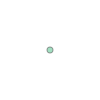

In [13]:
point = Point([x1, y1])
point

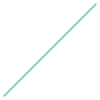

In [14]:
line = LineString([(x1,y1),(x3,y3)])
line

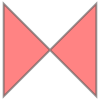

In [10]:
Polygon([(x2,y2),(x3,y3),(x1,y1),(x4,y4)])

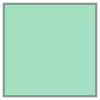

In [15]:
polygon = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)])
polygon

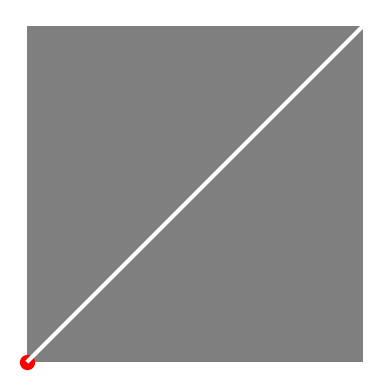

Point
LineString
Polygon


In [19]:
# 공간데이터 시각화

ax = gpd.GeoSeries(polygon).plot(color='black', alpha=0.5)

gpd.GeoSeries(line).plot(ax=ax, linewidth=3, color='white')

gpd.GeoSeries(point).plot(ax=ax, color="red", markersize=100)

plt.axis("off")

plt.show()

print(point.geom_type)
print(line.geom_type)
print(polygon.geom_type)